# PHYS-GA2059 - Statistics and Data Science for Physicists
# Student: Gehan Ranepura
## Problem Set #3 - Problem 2 
Go back to problem 2 of Problem Set 2. 

Hogg et al. (2010). Data analysis recipes: Fitting a model to data.
https://doi.org/10.48550/arXiv.1008.4686

- Which of the data sets contain another statistically significant sinusoidal signal at another period? What is the amplitude and period of that signal in each significant case? When you make those measurements, do so in a way that provides uncertainties, marginalizing out the 100-day-period signals.


What is the standard uncertainty on the period T of the second signal in data set 11 (the last of the 11 data sets)? Get this standard error by an analysis of the profile likelihood, profiling out all other parameters (including all amplitudes).

In [1]:
import sys
import pandas as pd
import numpy as np
import ipywidgets as widgets
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
import pylab as pyplt
import scipy as sci

from numpy.linalg import inv
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib import patches
from pylab import cm
from scipy import linalg
from scipy import stats
from scipy.optimize import minimize

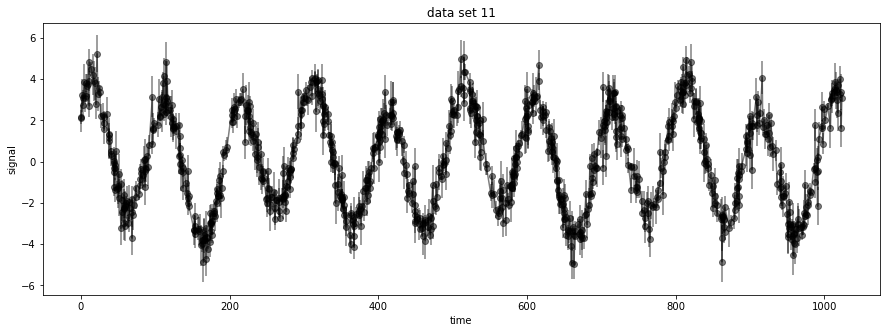

In [7]:
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`

# - data[0] is the array of times (day units, say?)
# - data[1] is the array of uncertainties (m/s units, say?)
# - data[2:13] are data sets (m/s units, say?).
# There are 11 data sets in all; they are illustrated in this code block.
for i in range(12, 13):
    pyplt.figure(figsize=(15, 5))
    pyplt.errorbar(data[0], data[i], yerr=data[1], color="k", marker="o", alpha=0.5)
    pyplt.xlabel("time")
    pyplt.ylabel("signal")
    pyplt.title("data set {}".format(i-1))

## Background for my solutions
By assuming that each dataset can be generated by a probablistic model of zero/one/two sinosoidal signals, we can build a set of models $M_0, M_1, M_2$.

### $M_2$
For the probabilistic model $M_2$, assuming the data contains two sinosoidal signal:

$$ 
\begin{align}
\mu_i &= A' \cos(\frac{2\pi}{T'} t +\phi') + A \cos(\frac{2\pi}{T} t +\phi) + \epsilon_i + B \\
\end{align}
$$

To account for the phases, we decompose the signals into sin and cos

$$ 
\begin{align}
\mu_i &= A_3 \cos(\frac{2\pi}{T'} t) + A_4 \sin(\frac{2\pi}{T'} t) + A_1 \cos(\frac{2\pi}{T} t) + A_2 \sin(\frac{2\pi}{T} t) + \epsilon_i + B \\
\end{align}
$$

where, 
- One signal has given period $T=100days$ and amplitudes $A_1$ and $A_2$ 
- A second signal has unknown period $T'$ and amplitudes $A_3$ and $A_4$
- A total DC shift $B$. 
- $\{(t_i,y_i)\}$ is the given data set, and $\epsilon_i \sim \mathcal{N}(0,\sigma_i^2)$ is the Gaussian noise for each data point with a mean of 0 and given variance $\sigma_i^2$.

## Solution - Problem Set 2 - Exercise 2 
#### Task: For each dataset above, is there another sinusoidal signal with a 100day period other than one in exercise 1?

Using model $M_2$ in the likelihood function ${\mathcal {L_2}}$:
$$ {\mathcal {L_2}} = -\frac{1}{2} \sum \limits _{i} ^{N} \frac{ [y_i - \mu_i]^2}{\sigma_i^2} $$

We can use the log-likelihood function to derive the maximum likelihood estimator of the parameters $ \theta = A_1, A_2, A_3, A_4, T', B$ given the data $X$
$${\displaystyle {\hat {\theta }}=\operatorname {argmax} _{A_1, A_2, A_3, A_4, T', B \in \theta}{\mathcal {L_2}}(\theta \mid X)} $$

By utlizing the profile approach, we will choose $T'$:
$$\theta = (T', A_1,A_2,A_3,A_4,B) = ( T', \alpha(T') )$$

Therefore, at each $T'$,
$$\hat{\alpha}(T')=\operatorname {argmax} _{\alpha(T') \in \theta} \mathcal{L_2}(\alpha(T')|X) $$


We can define the log-likelihood function by,
$$ loglike(pars, data, info) = \log\left[P(data|pars)\right] = \hat{\alpha}(T') = \displaystyle {\hat \theta } $$
where,
- pars: model parameters $(A_1,A_2,A_3,A_4,B)$
- data: data points ($t_i, y_i)$, $1xN$ arrays $( [t_1, ... ,t_N],[y_1, ..., y_N] )$
- info: $y_i$ uncertainties $(\sigma_i)$, a $1xN$ array $[\sigma_1,...,\sigma_N]$

In [3]:
# Create the definition for our log-likelihood function and what it returns
def loglike_M2(pars, data, info):
    Tp,A1,A2,A3,A4,B = pars
    t, y = data
    sig = info
    
    # Create function for mu, using 1st signal with period of T = 100days and 2nd signal with unknown period T'
    mu = A3 * np.cos(2* np.pi/Tp * t) + A4 * np.sin(2* np.pi/Tp * t)+ A1 * np.cos(2* np.pi/100 * t) + A2 * np.sin(2* np.pi/100 * t) + B 

    # Calculate likelood function for given pars, data and info
    return -0.5 * np.sum( ((y - mu)/sig )**2 )


## Test M2 log-likelihood function for simple case if Tp=1, A1=1, A2=1, A3=1, A4=1, B=0
theta = (1,1,1,1,1,0)
loglike_M2(theta, (data[0],data[2]), data[1])

-9265.33707108336

dataset 11, Tp_argmax_M2 = 268.9795918367347, res.status = 2, max(loglike) -657.9496125549276, argmax = [1.98577067 2.29574054 0.74407954 0.18206215 0.10609705] 
dataset 11,  A_argmax_M2_signal1 = 3.035409326118162, A_argmax_M2_signal2 = 0.7660293692422786  


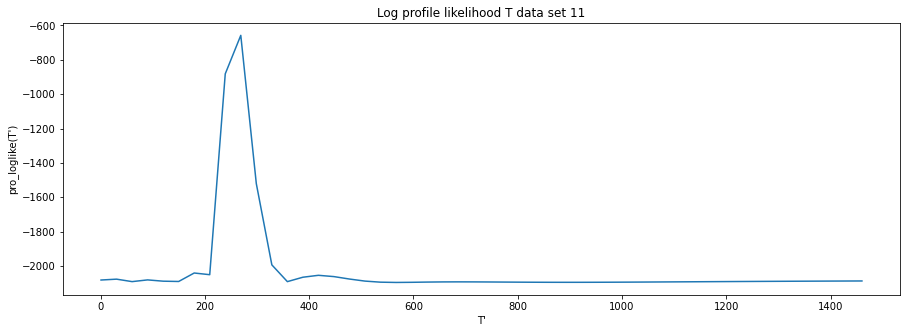

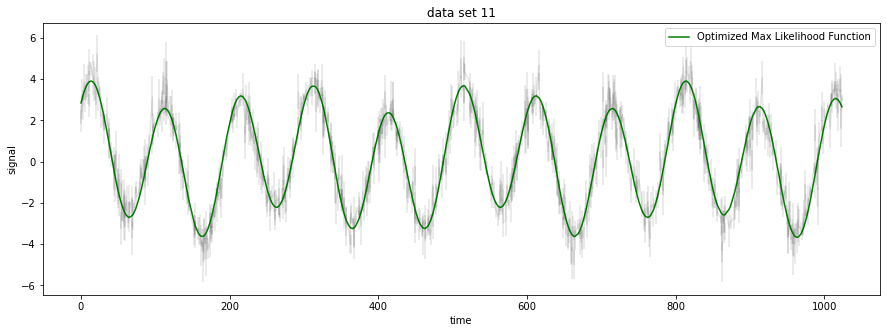

In [4]:
prologlike_s = pd.Series(dtype=object)
i = 12
Tps = np.linspace(1,1460,50)
prologlike_s.at[i] = []
for Tp in Tps:
    fun = lambda a: -loglike_M2( np.concatenate(([Tp],a)), (data[0],data[i]), data[1] )  
    res_Tp = minimize( fun, [1,1,1,1,1] )
    prologlike_s.at[i].append(-res_Tp.fun)  
    
Tp_max = pd.Series(dtype=object)
Maxloglike_M2_s = pd.Series(dtype=object)
argmaxloglike_M2_s = pd.Series(dtype=object)

# Plot Optimized Period vs log likelihood
Tp_max.at[i] = Tps[np.argmax(prologlike_s.at[i])]
pyplt.figure(figsize=(15, 5))
pyplt.plot(Tps, prologlike_s.at[i])
pyplt.xlabel("T'")
pyplt.ylabel("pro_loglike(T')")
pyplt.title("Log profile likelihood T data set {}".format(i-1))
    
# Reoptimize rest of parameters (A_1, A_2, A_3, A_4, B) using respective optimized T'
fun = lambda a: -loglike_M2( np.concatenate(([ Tp_max.at[i] ],a)), (data[0],data[i]), data[1] ) 
res = sci.optimize.minimize( fun, [1,1,1,1,1])
print("dataset {}, Tp_argmax_M2 = {}, res.status = {}, max(loglike) {}, argmax = {} ".format(i-1, Tp_max.at[i], res.status, -res.fun, res.x))  
    
Maxloglike_M2_s.at[i]= -res.fun  
argmaxloglike_M2_s.at[i]= res.x  

A1,A2,A3,A4,B = res.x                     # maximum likelihood parameters
A_ML_M2_signal1 = np.sqrt(A1**2 + A2**2)  # convert to original model parameters
A_ML_M2_signal2 = np.sqrt(A3**2 + A4**2)  # convert to original model parameters
    
# Plot function for optimized parameters (A_1, A_2, A_3, A_4, B) for each each respective T'
M2 = A3 * np.cos(2* np.pi/Tp_max.at[i] * data[0]) + A4 * np.sin(2* np.pi/Tp_max.at[i] * data[0]) + A1 * np.cos(2* np.pi/100 * data[0]) + A2 * np.sin(2* np.pi/100 * data[0]) + B
print("dataset {},  A_argmax_M2_signal1 = {}, A_argmax_M2_signal2 = {}  ".format(i-1, A_ML_M2_signal1, A_ML_M2_signal2 ))
   
pyplt.figure(figsize=(15, 5))
pyplt.errorbar(data[0], data[i], yerr=data[1], color="k", alpha=0.1)
pyplt.plot(data[0], M2, color='g', alpha=1.0, label = 'Optimized Max Likelihood Function')
pyplt.xlabel("time")
pyplt.ylabel("signal")
pyplt.title("data set {}".format(i-1))
plt.legend()

## Solution - Problem Set 2 - Exercise 2 
#### Task: What is the standard uncertainty on the period T of the second signal in data set 11 (the last of the 11 data sets)? Get this standard error by an analysis of the profile likelihood, profiling out all other parameters (including all amplitudes).

In [5]:
df = pd.read_pickle("./data.pkl") 
X_data = df[:,0]
Y_data_err = df[:,1]
Y_data = df[:,-1]

T0 = 100
T_list = np.append(np.linspace(1,80,80), np.linspace(120,400,281)) # append two arrays that exclude the T=100 region.

likelihood = []
for Tp in T_list:
    #calc. chi_sq
    def chi_sq(params):
        A1, A2, B = 2.06095, 2.31405, 0.03377
        A3, A4 = params[0], params[1]
        y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B + \
                 A3*np.cos(2*np.pi*X_data[i]/Tp) + A4*np.sin(2*np.pi*X_data[i]/Tp) \
                 for i in range(len(X_data))]
        func_list = [(Y_data[i]-y_fit[i])**2/Y_data_err[i]**2 for i in range(len(X_data))]
        ans = np.sum(func_list)
        return ans
    LL_model = minimize(chi_sq, np.array([1,1]), method = 'L-BFGS-B',tol = 1e-6) #minimize chi-square
    A3, A4 = LL_model.x[0], LL_model.x[1]
    likelihood.append(-1/2*chi_sq([A3, A4]))

#deal with uncertainties
covar = LL_model.hess_inv
covar = covar * np.identity(covar.shape[1]) 
A3_err = np.sqrt(covar[0][0])*1e-3
A4_err = np.sqrt(covar[1][1])*1e-3    

uncertainty in T = 26.0 days


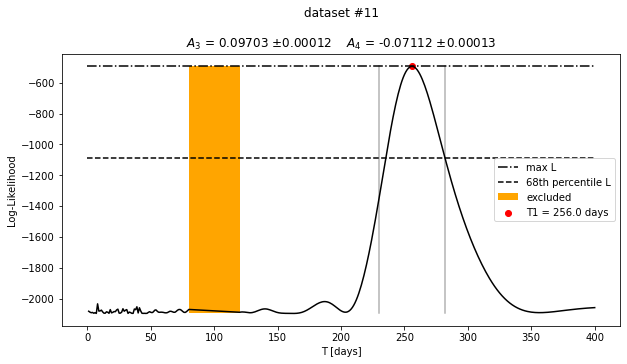

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(T_list, likelihood,'k-')

index_max = max(range(len(likelihood)), key=likelihood.__getitem__)
index_min = min(range(len(likelihood)), key=likelihood.__getitem__)
conf68 = 0.68*(abs(likelihood[index_max])-abs(likelihood[index_min]))
index_conf68 = min(range(len(likelihood)), key=lambda i: abs(likelihood[i]-conf68))
dt = abs(T_list[index_max]-T_list[index_conf68])
print('uncertainty in T = {} days'.format(dt))

ax.scatter([T_list[index_max]],[likelihood[index_max]],marker = 'o', c='red',\
           label = r'T1 = {} days'.format(round(T_list[index_max],2)))
ax.plot([0,400],[likelihood[index_max], likelihood[index_max]], 'k-.', label = 'max L')
ax.plot([0,400],[conf68, conf68], 'k--', label = '68th percentile L')
ax.plot([T_list[index_max]-dt,T_list[index_max]-dt],[likelihood[index_min],likelihood[index_max]], 'k-',alpha = 0.3)
ax.plot([T_list[index_max]+dt,T_list[index_max]+dt],[likelihood[index_min],likelihood[index_max]], 'k-',alpha = 0.3)

ax.set_xlabel('T [days]')
ax.set_ylabel('Log-Likelihood')
str1 = 'dataset #{}\n'.format(11) + '\n'
str2 = r'$A_3$ = {} $\pm$'.format(round(A3,5)) + '{}'.format(round(A3_err,5)) + '\t'
str3 = r'$A_4$ = {} $\pm$'.format(round(A4,5)) + '{}'.format(round(A4_err,5))
ax.set_title(str1+str2+str3)


rectangle = patches.Rectangle((80, min(likelihood)), 40, abs(max(likelihood) - min(likelihood)), edgecolor='None',\
                              facecolor="orange", zorder=2, label = 'excluded')
ax.add_patch(rectangle)

_=ax.legend()